# next
test update_neuronal_states with inhibitory synnapses

In [18]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [50,50]

import brain; import importlib; importlib.reload(brain);

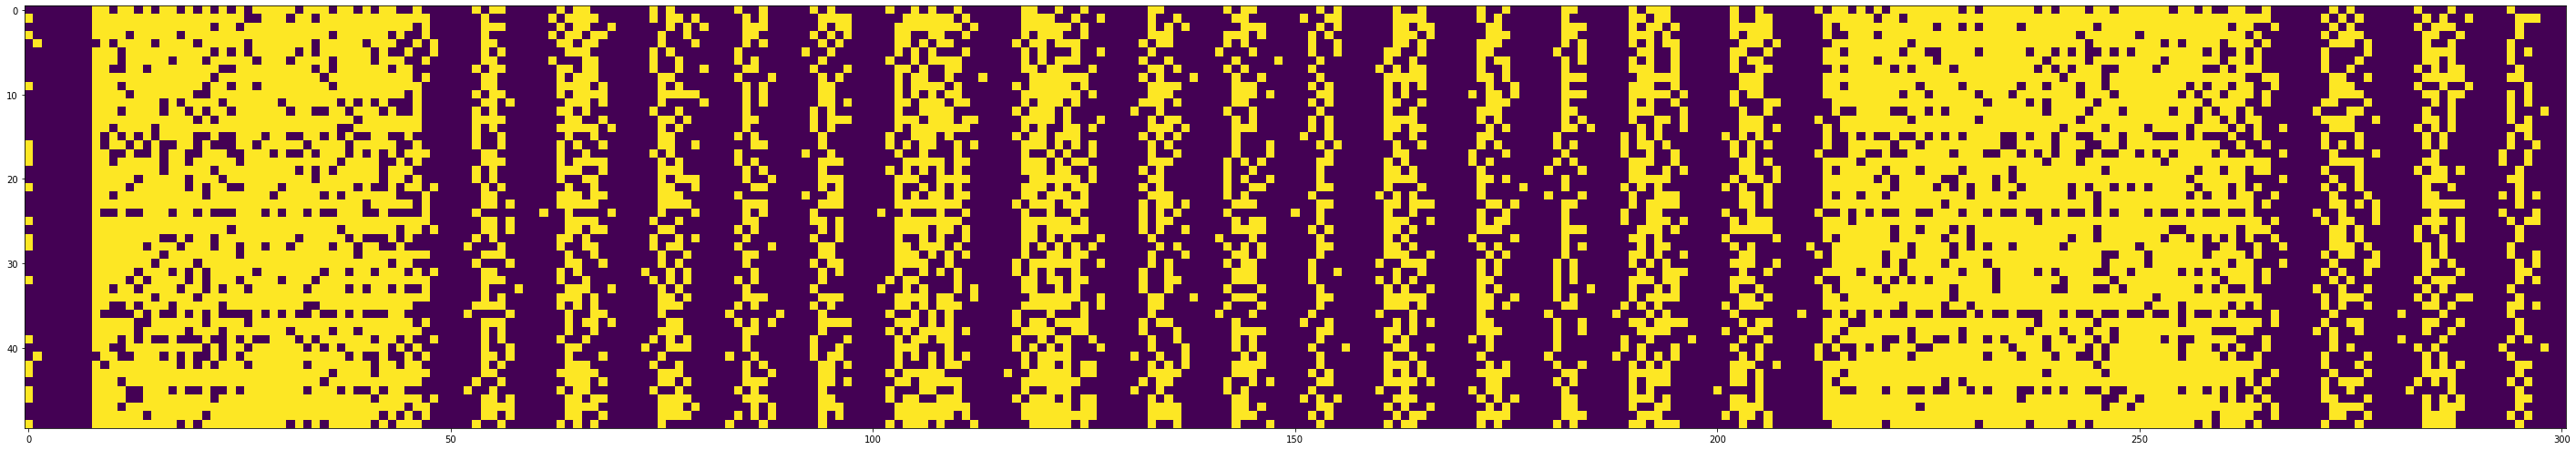

In [25]:
b = brain.Brain(
    num_neurons=50, 
    excitatory_synaptic_density=0.40,
    inhibitory_synaptic_density=0,
    initial_active_neuron_density=.3,
    neuronal_max_threshold=6,
)
b.simulate_brain(300)

In [ ]:
brain.simulate_brain(300)

# next

* get a better plot
* make the activation threshold of the neurons drain as time goes on unless they activate, then they get the max threshold

# ideas
1. represent inhibitory synapses with negative S_a

In [26]:
np.array([[1],[1]])

array([[1],
       [1]])